This notebook is for TAD boundaries calling in Danio rerio project (2022). HiChew functions adopted.

# Import dependecies

In [3]:
import sys
import time
import warnings
import logging
import random
import json
from os.path import join, basename, splitext
from os import listdir

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cooler
import cooltools

import hichew
from hichew.calling import boundaries, domains, clusters
from hichew.compute import normalize, d_scores, insulation_scores, silhouette
from hichew.loader import cool_files
from hichew.plot import clusters_dynamics, viz_opt_curves, viz_tads, _pca, _tsne


/Users/encent/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import logging
import time
import operator
import os
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift

from hichew.lib import utils

In [5]:
sns.set(context='paper', style='whitegrid')
warnings.filterwarnings("ignore")

In [6]:
%matplotlib inline

# Specify parameters

In [10]:
stage_calling_path = '../arcuda/coolers/This2022/sperm.danrer11-reduced.mapq_30.1000.mcool'
stage_calling = splitext(basename(stage_calling_path))[0]
resolution = 10000 # 20000
expected_tad_size = 500000 # 1000000

# Get data

#### Chromosome armsizes

In [11]:
# chromosome armsizes

chromosome_armsizes_path = '../arcuda/genome/danRer11.armsizes.txt'
chromosome_armsizes_data = pd.read_csv(chromosome_armsizes_path)
chromosome_armsizes_data = chromosome_armsizes_data.iloc[:-1]
chromosomes = list(chromosome_armsizes_data.chrom.drop_duplicates())
# chromosomes = ['chr1']

chromosome_armsizes_dict = dict.fromkeys(chromosomes, None)
for chrom in chromosomes:
    left = chromosome_armsizes_data[chromosome_armsizes_data['chrom'] == chrom].iloc[0]
    right = chromosome_armsizes_data[chromosome_armsizes_data['chrom'] == chrom].iloc[1]
    chromosome_armsizes_dict[chrom] = {'left': (left.start, left.end), 'right': (right.start, right.end)}

#### Cooler

In [12]:
matrices, coolers = cool_files(stage_calling_path, resolution=resolution, chromnames=chromosomes)

INFO:root:LOADER|COOL_FILES| List of coolfiles of interest: ['../arcuda/coolers/This2022/sperm.danrer11-reduced.mapq_30.1000.mcool']
INFO:root:LOADER|COOL_FILES| Start loading coolfiles...
INFO:root:LOADER|COOL_FILES| Loading completed in 0m 30s


# Call boundaries

In [13]:
ver1 = {'Wild-Type_25.danrer11-reduced.mapq_30.1000': 0.9,
        'Wild-Type_11.danrer11-reduced.mapq_30.1000': 0.9, 
        'Wild-Type_5.3.danrer11-reduced.mapq_30.1000': 0.9, 
        'Wild-Type_2.75.danrer11-reduced.mapq_30.1000': 0.97, 
        'WT.danrer11-reduced.mapq_30.1000': 0.85, 
        'sperm.danrer11-reduced.mapq_30.1000': 0.97, 
        'TR.danrer11-reduced.mapq_30.1000': 0.9, 
        'embryos_2.3hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'embryos_4hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'embryos_8hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'embryos_24hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'Wike2021_WT_ZF_Embryos_2.25hpf_ED.danrer11-reduced.mapq_30.1000': 0.9,
        'Wike2021_WT_ZF_Embryos_2.25hpf_LD.danrer11-reduced.mapq_30.1000': 0.9, 
        'Wike2021_WT_ZF_Embryos_4hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'Wike2021_WT_ZF_Embryos_5.3hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'Wike2021_WT_ZF_Embryos_24hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'Wike2021_WT_ZF_Sperm.danrer11-reduced.mapq_30.1000': 0.9}

In [14]:
ver2 = {'Wild-Type_25.danrer11-reduced.mapq_30.1000': 0.95, 
        'Wild-Type_11.danrer11-reduced.mapq_30.1000': 0.95, 
        'Wild-Type_5.3.danrer11-reduced.mapq_30.1000': 0.9, 
        'Wild-Type_2.75.danrer11-reduced.mapq_30.1000': 0.97, 
        'WT.danrer11-reduced.mapq_30.1000': 0.9, 
        'sperm.danrer11-reduced.mapq_30.1000': 0.95, 
        'TR.danrer11-reduced.mapq_30.1000': 0.95, 
        'embryos_2.3hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'embryos_4hpf.danrer11-reduced.mapq_30.1000': 0.95, 
        'embryos_8hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'embryos_24hpf.danrer11-reduced.mapq_30.1000': 0.95, 
        'Wike2021_WT_ZF_Embryos_2.25hpf_ED.danrer11-reduced.mapq_30.1000': 0.95, 
        'Wike2021_WT_ZF_Embryos_2.25hpf_LD.danrer11-reduced.mapq_30.1000': 0.95, 
        'Wike2021_WT_ZF_Embryos_4hpf.danrer11-reduced.mapq_30.1000': 0.95, 
        'Wike2021_WT_ZF_Embryos_5.3hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'Wike2021_WT_ZF_Embryos_24hpf.danrer11-reduced.mapq_30.1000': 0.9, 
        'Wike2021_WT_ZF_Sperm.danrer11-reduced.mapq_30.1000': 0.9}

In [762]:
%%time
BOUNDARIES_df, \
BOUNDARIES_df_opt, \
BOUNDARIES_stats, \
BOUNDARIES_opt_windows = boundaries(matrices, coolers, label=stage_calling, expected_tad_size=expected_tad_size, 
                                    chromnames=chromosomes, filtration='custom', bs_thresholds=ver1)

INFO:root:CALL|BOUNDARIES| Start search optimal annotation...
INFO:root:CALL|BOUNDARIES| Start chromosome chr1
INFO:root:CALL|BOUNDARIES| For chromosome chr1 with 5958 bins we have 5602 good bins and expected count of TADs (according to expected TAD size) of 56.0
INFO:root:CALL|BOUNDARIES| Run TAD boundaries search using windows grid for chromosome chr1...
INFO:root:CALL|BOUNDARIES| Run TAD boundaries search for boundary strength threshold 0.97...
INFO:root:CALL|BOUNDARIES| Found optimal window for chrm chr1 and boundary strength threshold 0.97: 220000
INFO:root:CALL|BOUNDARIES| End boundary strength threshold 0.97
INFO:root:CALL|BOUNDARIES| For stage sperm.danrer11-reduced.mapq_30.1000 for chrom chr1 boundary strength percentile is 0.97
INFO:root:CALL|BOUNDARIES| End chromosome chr1
INFO:root:CALL|BOUNDARIES| Start chromosome chr2
INFO:root:CALL|BOUNDARIES| For chromosome chr2 with 5965 bins we have 5658 good bins and expected count of TADs (according to expected TAD size) of 56.0
INF

INFO:root:CALL|BOUNDARIES| End chromosome chr9
INFO:root:CALL|BOUNDARIES| Start chromosome chr10
INFO:root:CALL|BOUNDARIES| For chromosome chr10 with 4543 bins we have 4362 good bins and expected count of TADs (according to expected TAD size) of 43.0
INFO:root:CALL|BOUNDARIES| Run TAD boundaries search using windows grid for chromosome chr10...
INFO:root:CALL|BOUNDARIES| Run TAD boundaries search for boundary strength threshold 0.97...
INFO:root:CALL|BOUNDARIES| Found optimal window for chrm chr10 and boundary strength threshold 0.97: 90000
INFO:root:CALL|BOUNDARIES| End boundary strength threshold 0.97
INFO:root:CALL|BOUNDARIES| For stage sperm.danrer11-reduced.mapq_30.1000 for chrom chr10 boundary strength percentile is 0.97
INFO:root:CALL|BOUNDARIES| End chromosome chr10
INFO:root:CALL|BOUNDARIES| Start chromosome chr11
INFO:root:CALL|BOUNDARIES| For chromosome chr11 with 4549 bins we have 4301 good bins and expected count of TADs (according to expected TAD size) of 43.0
INFO:root:C

INFO:root:CALL|BOUNDARIES| For stage sperm.danrer11-reduced.mapq_30.1000 for chrom chr18 boundary strength percentile is 0.97
INFO:root:CALL|BOUNDARIES| End chromosome chr18
INFO:root:CALL|BOUNDARIES| Start chromosome chr19
INFO:root:CALL|BOUNDARIES| For chromosome chr19 with 4845 bins we have 4618 good bins and expected count of TADs (according to expected TAD size) of 46.0
INFO:root:CALL|BOUNDARIES| Run TAD boundaries search using windows grid for chromosome chr19...
INFO:root:CALL|BOUNDARIES| Run TAD boundaries search for boundary strength threshold 0.97...
INFO:root:CALL|BOUNDARIES| Found optimal window for chrm chr19 and boundary strength threshold 0.97: 260000
INFO:root:CALL|BOUNDARIES| End boundary strength threshold 0.97
INFO:root:CALL|BOUNDARIES| For stage sperm.danrer11-reduced.mapq_30.1000 for chrom chr19 boundary strength percentile is 0.97
INFO:root:CALL|BOUNDARIES| End chromosome chr19
INFO:root:CALL|BOUNDARIES| Start chromosome chr20
INFO:root:CALL|BOUNDARIES| For chromo

CPU times: user 17min 31s, sys: 2min 10s, total: 19min 42s
Wall time: 21min 35s


In [763]:
BOUNDARIES_df_opt.to_csv('../arcuda/boundaries/{}_{}Kb_097_1Mb.csv'.format(stage_calling, resolution // 1000), index=None)

In [764]:
BOUNDARIES_df_opt.shape

(649, 7)

In [18]:
BOUNDARIES_df_opt = pd.read_csv('../arcuda/boundaries/filtered/{}.csv'.format(stage_calling))


In [19]:
BOUNDARIES_df_opt.shape

(649, 7)

In [20]:
stage_calling

'sperm.danrer11-reduced.mapq_30.1000'

## Visualize boundaries

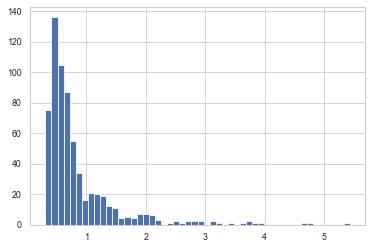

In [21]:
BOUNDARIES_df_opt.boundary_strength.hist(bins=50)

In [22]:
i = 0

In [23]:
matrices[stage_calling][chromosomes[i]].shape

(5958, 5958)

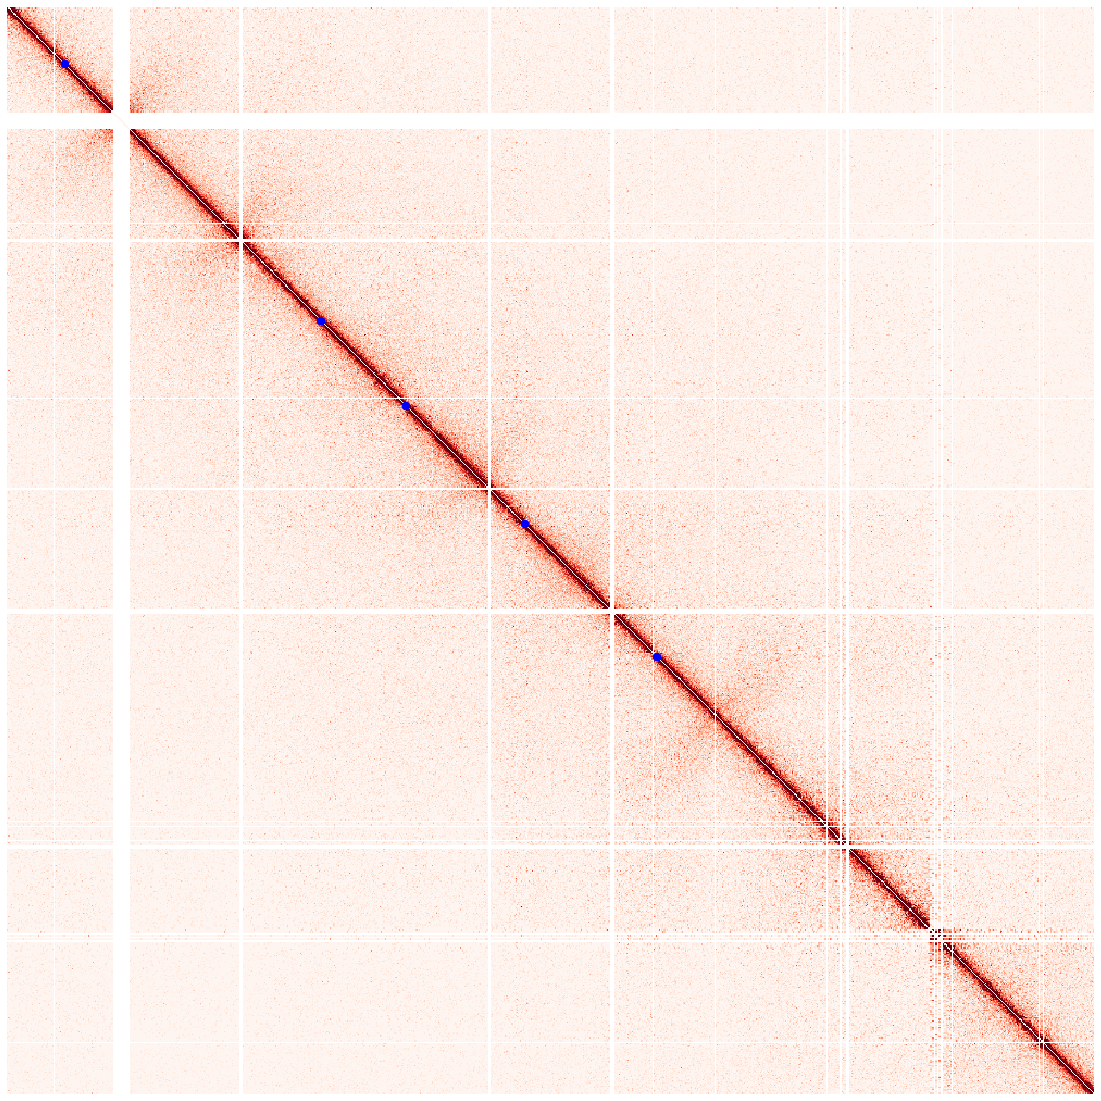

In [27]:
viz_tads(BOUNDARIES_df_opt, matrices, begin=2000, end=3000, ch=chromosomes[i], exp=stage_calling, 
         resolution=resolution, is_insulation=True, percentile=99.9)

**Wild-Type_2.75.danrer11-reduced.mapq_30.1000 -- a little of boundaries, mainly rearrangements (visual inspection)**

**sperm.danrer11-reduced.mapq_30.1000 -- a little of boundaries, mainly "boundaries" of so-called "flares" (by Wike et al., 2021)**

**The rest stages -- reasonable boundaries detection**